<a href="https://colab.research.google.com/github/EnesGokceDS/Take_Home_Challenge_Relax-Inc.ipynb/blob/master/Take_Home_Challenge_Relax_Inc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import subprocess as sp
import sys,os,shutil,pickle,time
from os.path import join
# mount Google Drive
from os.path import expanduser
gd_path=join(expanduser("~"),'gd')
if not os.path.isdir(gd_path):
    try:
        # load Google Drive
        from google.colab import drive,files
        drive.mount('/drive')
        sp.call('ln -s /drive/My\ Drive '+gd_path, shell=True)
    except:
        print('unable to find Google Drive Folder')
os.chdir(gd_path+'/MachineLearning/relax_challenge')
os.listdir('.')

['takehome_users.csv',
 'takehome_user_engagement.csv',
 'relax_data_science_challenge.pdf']

In [0]:
import pandas as pd
engagement = pd.read_csv('takehome_user_engagement.csv')
df = pd.read_csv('takehome_users.csv', encoding = 'latin') #Getting the data loaded

In [68]:
df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [0]:
# selecting only the users who appear at least 3 times anyway since they can't occur three times in a week with less than 3 occurances\n",
engage = engagement.groupby('user_id').filter(lambda x: len(x) >= 3)

engage.reset_index(drop=True, inplace = True) # by removing the rows the index is now off, so reset

In [0]:
#this sequence runs through the dataframe, creates a week from a date, and then checks if the next two dates fall within that\n",
#time. Then it ouputs the user_id to a list.\n",
active = 0
active_users = []
for i in range(len(engage)-2):
  user = engage['user_id'][i] #get current user_id
  if user != active and user == engage['user_id'][i+2]: #so we can skip a user that has already been active and to make sure we don't compare to the next user
    st = pd.Timestamp(engage['time_stamp'][i]) #get start date
    et = st + pd.Timedelta('7D') # make range for end date
  if st < pd.Timestamp(engage['time_stamp'][i+1]) < et and st < pd.Timestamp(engage['time_stamp'][i+2]) < et:
    active_users.append(user) # now that the active condition has been met, return that user
    active = user   #define the user as active

In [72]:
len(active_users)

2160

In [73]:
import numpy as np

y = pd.Series(np.random.randn(len(df)))
n = 0
for i in range(len(df)):
  if df['object_id'][i] == active_users[n]:
    y[i] = 1
    n = n+1
  if n > len(active_users)-1:
    n = n -1
  else:
    y[i] = 0

y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

In [0]:
df1 = pd.DataFrame(y,columns = ['active_users'])

In [0]:
df = pd.concat([df,df1], axis = 1)

In [76]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_users
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [0]:
# This is to turn the invited column into simply a binary 'was invited' or 'not'
inv = pd.Series(np.random.randn(len(df)))
for i in range(len(df)):
  if df['invited_by_user_id'][i] >=1:
    inv[i] = 1
  else:
    inv[i] = 0

df2 = pd.DataFrame(inv, columns = ['invited'])
df = pd.concat([df,df2], axis = 1)

In [78]:
inv.value_counts()

1.0    6417
0.0    5583
dtype: int64

Now, we have identified the active users and identified them in the dataframe as the column active_users so that we can now use that to discover which features predict active users.

One thing to note here is that the early creation times did not produce active users as frequently.

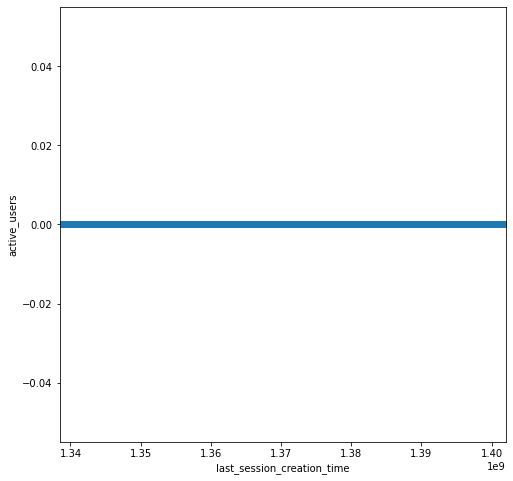

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
sns.regplot(y=df['active_users'], x=df['last_session_creation_time'], fit_reg = True)

In [80]:
df['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

# **Making Predictions**

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df[['creation_time', 'name', 'email', 'creation_source']] = df[['creation_time', 'name', 'email', 'creation_source']].apply(le.fit_transform)

In [0]:
# df[['creation_time', 'name', 'email', 'creation_source']] = df[['creation_time', 'name', 'email', 'creation_source']].apply(le.fit_transform)
# df[['ORG_INVITE','GUEST_INVITE','PERSONAL_PROJECTS','SIGNUP','SIGNUP_GOOGLE_AUTH']] = df[['ORG_INVITE','GUEST_INVITE','PERSONAL_PROJECTS','SIGNUP','SIGNUP_GOOGLE_AUTH']].apply(le.fit_transform)

In [0]:
df3 = pd.DataFrame(creation,columns = ['creation'])

In [0]:
df = pd.concat([df,df3],axis=1)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  int64  
 2   name                        12000 non-null  int64  
 3   email                       12000 non-null  int64  
 4   creation_source             12000 non-null  int64  
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  active_users                12000 non-null  float64
 11  invited                     12000 non-null  float64
 12  creation                    12000 non-null  int64  
dtypes: float64(4), int64(9)
memory 

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

y = df['active_users']
X = df[['creation','creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id']]

In [99]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)

model = XGBClassifier() # fit model to training data
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# make predictions for test data
y_pred = model.predict(X_test)

In [101]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred)))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred)))

Accuracy score: 1.00
Precision score: 0.00
Recall score: 0.00


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
rf_fit= rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred)))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred)))
print('F1 score: {0:0.2f}'.format(f1_score(y_test, y_pred, average='micro')))

Accuracy score: 1.00
Precision score: 0.00
Recall score: 0.00
F1 score: 1.00


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
